**HEALIOS Thermal Analysis - Algorithm Showcase**

Mateusz Boćko

In [1]:
# ------------- MODULES  -------------
# pip install numpy pandas matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.lines as mlines
from matplotlib.colors import Normalize

# ------------- CONSTANTS  -------------

# Direct solar heat flux (W/m^2)
q_S_hc = 1419
q_S_cc = 1317

# Albedo coefficient
a_hc = 0.59
a_cc = 0.22

# Earth IR heat flux (W/m^2)
q_IR_hc = 261
q_IR_cc = 217

# Stefan-Boltzmann constant (W/m^2·K^4)
sigma = 5.670e-8

# Deep space temperature (K)
T_space = 2.73

# Gravitational constant (m^3 / (kg·s^2))
G = 6.67430e-11

# Mass of the Earth (kg)
M_earth = 5.9722e24

# Radius of the Earth (equatorial) (m)
R_earth = 6.3781e6

# Orbit altitude (m)
h_orbit = 400000

# Orbit beta angle, radians
beta = np.radians(45)

In [2]:
# Simplified geometry: CubeSat and 2 1U size Solar Arrays

nodes = {
    0: "INTERIOR",
    1: "WALL +X",   # 10 cm x 10 cm; Sun-Pointing
    2: "WALL -X",
    3: "WALL +Y",   # 10 cm x 10 cm
    4: "WALL -Y",
    5: "WALL +Z",   # 10 cm x 10 cm
    6: "WALL -Z",
    7: "SOLAR PANEL +Y",
    8: "SOLAR PANEL -Y"
}

N = len(nodes)
print(N)

node_index = {name: i for i, name in nodes.items()}

9


In [3]:
# Thermal properties
emissivity = 0.520  # ε (epsilon)
absorptivity = 0.419  # α (alpha)

# Satellite specifications
# satellite_size = "1U"
m_sp = 0.05       # kg
m_payload = 1.0     # kg
satellite_mass = 8*m_sp + m_payload  # kg

# Specific heat capacity (J/kg/K)
c_p_sp = 900.75
c_p_payload = 963.85

c_p = (c_p_sp * 8*m_sp / satellite_mass) + (c_p_payload * m_payload / satellite_mass)  # J/kg/K


print(f"Satellite mass: {satellite_mass} kg\nSatellite specific heat capacity: {c_p} J/kg/K")

C = np.zeros(N)

# ---- INTERIOR ----
C[node_index["INTERIOR"]] = m_payload * c_p_payload

# ---- Structure (6 faces) ----
m_wall = m_sp
for name in ["WALL +X","WALL -X","WALL +Y","WALL -Y","WALL +Z","WALL -Z", "SOLAR PANEL +Y", "SOLAR PANEL -Y"]:
    C[node_index[name]] = m_wall * c_p_sp


Satellite mass: 1.4 kg
Satellite specific heat capacity: 945.8214285714287 J/kg/K


In [4]:
absorptivity    = np.zeros(N)
emissivity      = np.zeros(N)
area            = np.zeros(N)

for i in nodes:
    absorptivity[i] = 0.52
    emissivity[i]   = 0.419
    area[i]         = 0.01

emissivity[node_index["SOLAR PANEL +Y"]]   = 0.419 + 0.660
emissivity[node_index["SOLAR PANEL -Y"]]   = 0.419 + 0.660

absorptivity[node_index["INTERIOR"]] = 0.0
emissivity[node_index["INTERIOR"]]   = 0.0
area[node_index["INTERIOR"]]         = 0.0

absorptivity[node_index["WALL -X"]] = 0.25
emissivity[node_index["WALL -X"]]   = 0.10

absorptivity[node_index["WALL +Z"]] = 0.1
emissivity[node_index["WALL +Z"]]   = 0.66

absorptivity[node_index["WALL -Z"]] = 0.1
emissivity[node_index["WALL -Z"]]   = 0.66

In [5]:
K = np.zeros((N, N))

def cond(i, j, k):
    """
    Define thermal conductance between node i and j.

    Parameters
    ----------
    i, j : int
        Node IDs
    k : float
        Thermal conductance [W/K]
    """

    if i == j:
        raise ValueError("Self-conductance is not allowed")

    if not (0 <= i < N and 0 <= j < N):
        raise ValueError("Node index out of range")

    K[i, j] = k
    K[j, i] = k

cond(0, 1,  0.288)    # INTERIOR ↔ WALL +X
cond(0, 2,  0.288)    # INTERIOR ↔ WALL −X
cond(0, 3,  0.631)    # INTERIOR ↔ WALL +Y
cond(0, 4,  0.631)    # INTERIOR ↔ WALL −Y
cond(0, 5,  0.631)    # INTERIOR ↔ WALL +Z
cond(0, 6,  0.631)    # INTERIOR ↔ WALL −Z

cond(1, 3,  0.28543)    # WALL +X ↔ WALL +Y
cond(1, 4,  0.28543)    # WALL +X ↔ WALL −Y
cond(1, 5,  0.28543)    # WALL +X ↔ WALL +Z
cond(1, 6,  0.28543)    # WALL +X ↔ WALL −Z

cond(2, 3,  0.28543)    # WALL −X ↔ WALL +Y
cond(2, 4,  0.28543)    # WALL −X ↔ WALL −Y
cond(2, 5,  0.28543)    # WALL −X ↔ WALL +Z
cond(2, 6,  0.28543)    # WALL −X ↔ WALL −Z

cond(3, 5,  0.28543)    # WALL +Y ↔ WALL +Z
cond(3, 6,  0.28543)    # WALL +Y ↔ WALL −Z
cond(4, 5,  0.28543)    # WALL −Y ↔ WALL +Z
cond(4, 6,  0.28543)    # WALL −Y ↔ WALL −Z

cond(3, 7,  0.000)    # WALL +Y ↔ SOLAR PANEL +Y
cond(4, 8,  0.000)    # WALL −Y ↔ SOLAR PANEL -Y

def build_G_cond(K):
    G_cond = -K.copy()
    np.fill_diagonal(G_cond, np.sum(K, axis=1))
    return G_cond

G_cond = build_G_cond(K)

def make_Q_cond(G_cond):
    """
    e.g., Q_cond(T)
    Build the conductive heat-flow operator for a fixed thermal network.
    Creates a closure: Q_cond(T) = - G_cond @ T.
    
    Parameters
    ----------
    G_cond : ndarray (N,N)
        Thermal conductance matrix [W/K]
    
    Returns
    -------
    Q_cond : callable
        Function Q_cond(T) that maps node temperatures [K] to conductive heat flows [W].
    """
    
    G_cond = np.ascontiguousarray(G_cond)
    
    def Q_cond(T):
        """
        Compute conductive heat flow vector for all nodes.

        Parameters
        ----------
        T : ndarray (N,)
            Node temperatures [K]

        Returns
        -------
        Q_cond : ndarray (N,)
            Conductive heat flow into each node [W]
        """
        return -G_cond @ T
    return Q_cond

Q_cond = make_Q_cond(G_cond)

In [6]:
def make_is_Sun(beta: float):
    """
    e.g., is_Sun(12)
    Precomputes orbital eclipse geometry for a fixed Sun–orbit angle β and
    returns a fast time-dependent illumination function.

    Parameters
    ----------
    beta : float
        Sun–orbit plane angle (β-angle) in radians. This is the angle between
        the orbital plane and the Sun vector. It is assumed constant over
        the simulated orbit.

    Returns
    -------
    is_Sun : callable
    """

    total_time = float(2 * np.pi * np.sqrt((R_earth + h_orbit)**3 / (G * M_earth))) # s -> the orbital period of a satellite orbiting Earth in SI units.
    print(f"Total time: {total_time} s")

    # --- geometry ---
    beta_crt = np.arcsin(R_earth / (R_earth + h_orbit))

    if abs(beta) >= beta_crt:
        # no eclipse ever
        def is_Sun(t: float) -> int:
            return 1
        return is_Sun

    arg = np.sqrt(h_orbit * (h_orbit + 2*R_earth)) / ((R_earth + h_orbit) * np.cos(beta))
    arg = np.clip(arg, -1.0, 1.0)
    f_E = np.arccos(arg) / np.pi

    # --- timing ---
    t1 = 0.5 * total_time * (1 - f_E)
    t2 = 0.5 * total_time * (1 + f_E)

    # --- closure in solver ---
    def is_Sun(t: float) -> int:
        """
        Parameters
        ----------
        t : float
            Time since epoch [s]
            
        Returns
        -------
        1 if the spacecraft is illuminated by the Sun,
        0 if the spacecraft is in Earth eclipse.
        """
        t = t % total_time
        return 1 if (t < t1 or t > t2) else 0

    return is_Sun

# is_Sun = make_is_Sun(beta)

In [7]:
def make_Sun_view_factors(beta, total_time):

    def Sun_view_factors(t):

        F_S = np.zeros(N)

        # +X body axis locked to Sun
        F_S[node_index["WALL +X"]] = 1.0
        F_S[node_index["SOLAR PANEL +Y"]] = 1.0
        F_S[node_index["SOLAR PANEL -Y"]] = 1.0

        return F_S

    return Sun_view_factors


def make_Earth_view_factors(beta, total_time):
    """
    Calculates Earth view factors for a Sun-Pointing (+X) satellite.
    beta: radians, angle between Sun vector and Orbit Plane.
    """
    def F_E(t):
        t = t % total_time
        # Orbital angle (0 = Noon/Sub-Solar Point, pi = Midnight)
        theta = 2 * np.pi * t / total_time 
   
        # Ex: Component along the Sun line. 
        #     When cos(theta) is 1 (Noon), Ex is -cos(beta) (pointing to -X)
        Ex = -np.cos(beta) * np.cos(theta)
        
        # Ey/Ez: Transverse components. 
        Ey = np.sin(beta) * np.cos(theta) 
        Ez = np.sin(theta)

        # Note: You can rotate Ey/Ez logic depending on which way you 
        # assume the orbit normal points, but Ex is the critical one.

        F = np.zeros(N)

        # --- X FACES (The ones you were missing) ---
        F[node_index["WALL +X"]] = max(0.0, Ex)  # Sees Earth during Eclipse/Midnight
        F[node_index["WALL -X"]] = max(0.0, -Ex) # Sees Earth during Noon (+Heating!)

        # --- Y/Z FACES ---
        F[node_index["WALL +Y"]] = max(0.0, Ey)
        F[node_index["WALL -Y"]] = max(0.0, -Ey)
        F[node_index["WALL +Z"]] = max(0.0, Ez)
        F[node_index["WALL -Z"]] = max(0.0, -Ez)

        # --- NORMALIZE ---
        # Standard View Factor to Earth (approx r_earth^2 / r_orbit^2)
        # For LEO (500km), F_total is approx 0.3 to 0.4. 
        # It is NOT 1.0. 
        # The Earth does not cover the entire sky.
        # IF you want relative distribution summing to 1 (pure geometric distribution):
        s = F.sum()
        if s > 0:
            F /= s
            #print(F.sum())
            
        return F

    return F_E



In [ ]:
def make_Q_gen(nodes, beta, initial_battery_temperature = 300):

    total_time = float(2 * np.pi * np.sqrt((R_earth + h_orbit)**3 / (G * M_earth)))
    is_Sun = make_is_Sun(beta)

    HEATER_POWER = 3.5
    N_HEATERS = 1
    HEATER_ON_T  = 278.15   # 5 C
    HEATER_OFF_T = 280.15   # 7 C

    # INTERIOR
    HC_POWER = 5.87
    CC_POWER = 0

    heater_on = initial_battery_temperature < HEATER_ON_T

    def Q_gen(t, battery_temperature, HC_case = True):

        nonlocal heater_on

        Q_g = np.zeros(len(nodes))

        sun = is_Sun(t)
        
        if HC_case:
            Q_g[node_index["INTERIOR"]] = HC_POWER
        else:
            Q_g[node_index["INTERIOR"]]  = CC_POWER
    
        if heater_on:
            if battery_temperature > HEATER_OFF_T:
                heater_on = False
        else:
            if battery_temperature < HEATER_ON_T:
                heater_on = True
                #print("HEATER ON!")

        if heater_on:
        #if not sun:
            Q_g[node_index["INTERIOR"]] += N_HEATERS * HEATER_POWER

        return Q_g

    return Q_gen

# Q_gen = make_Q_gen(nodes, beta, initial_battery_temperature=293.15)

# Q_internal = Q_gen(t, T[node_index["BATTERY"]])


In [ ]:
def make_Q_in(beta):

    total_time = float(2 * np.pi * np.sqrt((R_earth + h_orbit)**3 / (G * M_earth)))

    is_Sun = make_is_Sun(beta)
    Sun_view_factors = make_Sun_view_factors(beta, total_time)
    Earth_view = make_Earth_view_factors(beta, total_time)

    absorptivity_local = absorptivity.copy()
    emissivity_local   = emissivity.copy()
    area_local         = area.copy()

    q_S_cc_local  = q_S_cc
    q_S_hc_local  = q_S_hc
    q_IR_cc_local = q_IR_cc
    q_IR_hc_local = q_IR_hc

    albedo_cc_local = a_cc
    albedo_hc_local = a_hc

    def Q_in(t):

        sun = is_Sun(t)

        F_S  = Sun_view_factors(t)
        F_A  = Earth_view(t)
        F_IR = Earth_view(t)
        
        if F_IR[node_index["WALL +X"]]*sun > 0.25:
            print("High Earth View on +X face!")

        Q_sun_cc = sun * absorptivity_local * area_local * F_S * q_S_cc_local
        Q_sun_hc = sun * absorptivity_local * area_local * F_S * q_S_hc_local

        Q_albedo_cc = sun * absorptivity_local * area_local * F_A * q_S_cc_local * albedo_cc_local
        Q_albedo_hc = sun * absorptivity_local * area_local * F_A * q_S_hc_local * albedo_hc_local

        Q_IR_cc = emissivity_local * area_local * F_IR * q_IR_cc_local
        Q_IR_hc = emissivity_local * area_local * F_IR * q_IR_hc_local

        Q_total_cc = Q_sun_cc + Q_albedo_cc + Q_IR_cc
        Q_total_hc = Q_sun_hc + Q_albedo_hc + Q_IR_hc

        return Q_total_cc, Q_total_hc

    return Q_in

# Q_in = make_Q_in(beta)
# Q_cc, Q_hc = Q_in(1200.0)   # 1200 seconds since epoch

In [10]:
sigma = 5.670374419e-8  # Stefan–Boltzmann

def Q_out(T, emissivity, area):
    return emissivity * area * sigma * (T**4 - T_space**4)

In [ ]:
Q_in = make_Q_in(beta)
Q_gen = make_Q_gen(nodes, beta, initial_battery_temperature=293)
Q_cond = make_Q_cond(G_cond)

def make_rhs(HC_case=True):

    def rhs(t, T):
        Qcc, Qhc = Q_in(t)
        Qin = Qhc if HC_case else Qcc

        Qg = Q_gen(t, T[node_index["INTERIOR"]], HC_case)

        Qc = Q_cond(T)

        Qr = Q_out(T, emissivity, area)

        return (Qin + Qg + Qc - Qr) / C

    return rhs

Total time: 5553.564148956816 s
Total time: 5553.564148956816 s


In [12]:
from scipy.integrate import solve_ivp

T0 = np.ones(N) * 293.15    # 20°C start
t_end = 30 * 3600
t_eval = np.linspace(0, t_end, 4000)

sol_HC = solve_ivp(make_rhs(True), (0, t_end), T0, t_eval=t_eval)
sol_CC = solve_ivp(make_rhs(False), (0, t_end), T0, t_eval=t_eval)

t_h = sol_HC.t / 3600

T_HC = sol_HC.y - 273.15
T_CC = sol_CC.y - 273.15

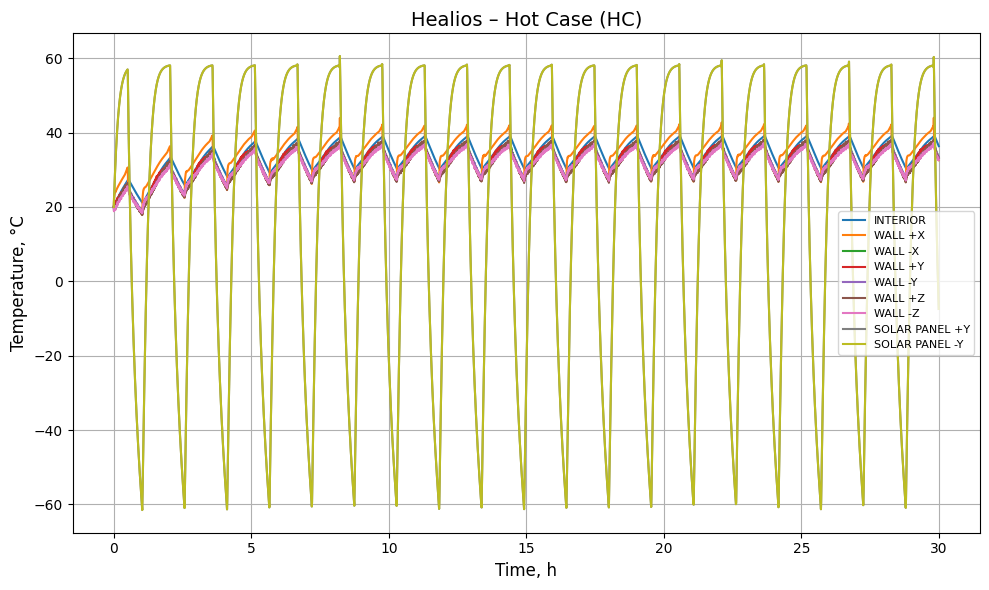

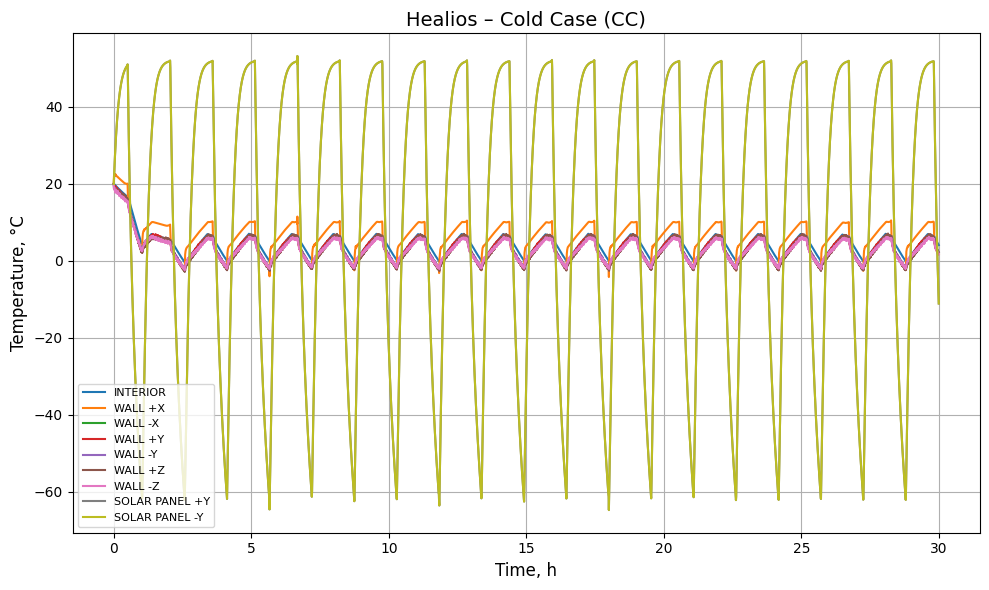

In [13]:
t_h = sol_HC.t / 3600.0
plt.figure(figsize=(10, 6))

for i in range(N):
    plt.plot(t_h, sol_HC.y[i] - 273.15, label=nodes[i])

plt.xlabel("Time, h", fontsize=12)
plt.ylabel("Temperature, °C", fontsize=12)
plt.title("Healios – Hot Case (HC)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=8, loc="best")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))

for i in range(N):
    plt.plot(t_h, sol_CC.y[i] - 273.15, label=nodes[i])

plt.xlabel("Time, h", fontsize=12)
plt.ylabel("Temperature, °C", fontsize=12)
plt.title("Healios – Cold Case (CC)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=8, loc="best")
plt.tight_layout()
plt.show()

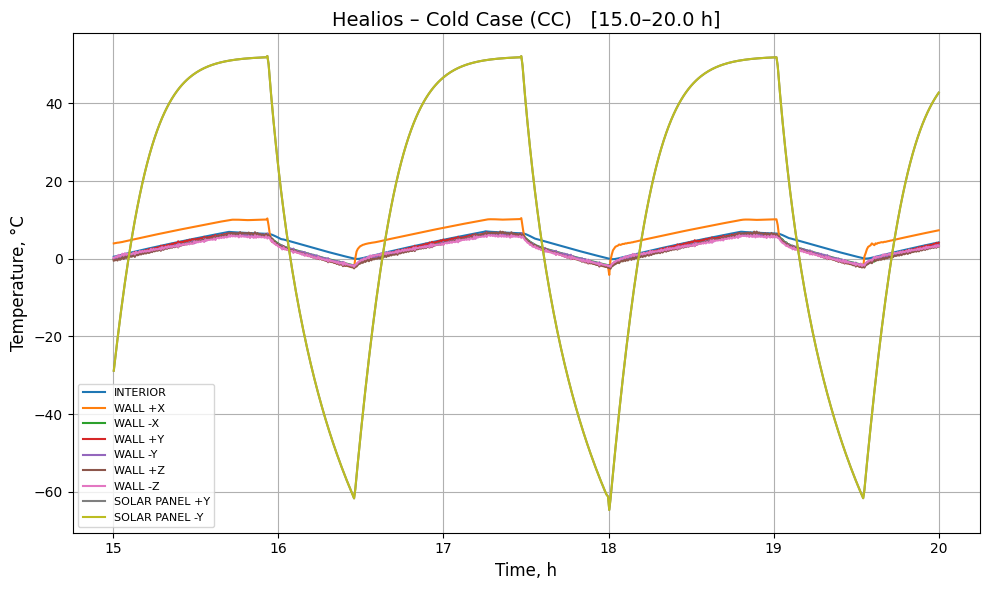

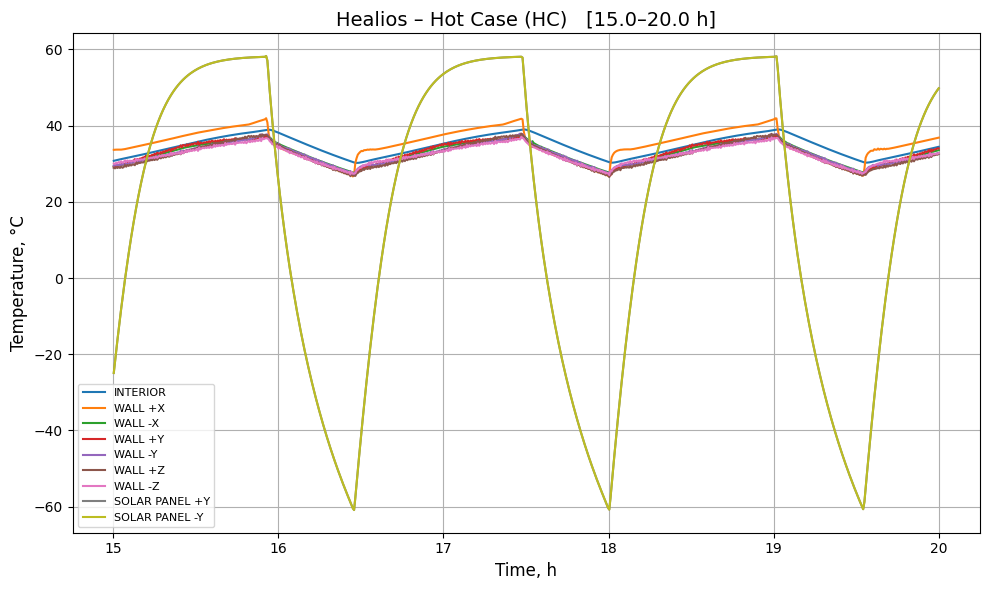

In [14]:
t_start = 15.0   # hours
t_end   = 20.0   # hours

mask = (t_h >= t_start) & (t_h <= t_end)

plt.figure(figsize=(10, 6))

for i in range(N):
    plt.plot(t_h[mask], sol_CC.y[i][mask] - 273.15, label=nodes[i])

plt.xlabel("Time, h", fontsize=12)
plt.ylabel("Temperature, °C", fontsize=12)
plt.title(f"Healios – Cold Case (CC)   [{t_start}–{t_end} h]", fontsize=14)
plt.grid(True)
plt.legend(fontsize=8, loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for i in range(N):
    plt.plot(t_h[mask], sol_HC.y[i][mask] - 273.15, label=nodes[i])

plt.xlabel("Time, h", fontsize=12)
plt.ylabel("Temperature, °C", fontsize=12)
plt.title(f"Healios – Hot Case (HC)   [{t_start}–{t_end} h]", fontsize=14)
plt.grid(True)
plt.legend(fontsize=8, loc="best")
plt.tight_layout()
plt.show()


In [15]:
import numpy as np

t_limit = 15.0   # hours

mask = t_h >= t_limit

T_HC = sol_HC.y - 273.15
T_CC = sol_CC.y - 273.15

print(f"=== Hot Case (HC) ===")
print(f"{'Node':<15} {'Min [°C]':>10} {'Max [°C]':>10}")
for i in range(N):
    Tmin = np.min(T_HC[i][mask])
    Tmax = np.max(T_HC[i][mask])
    print(f"{nodes[i]:<15} {Tmin:10.2f} {Tmax:10.2f}")

print(f"\n=== Cold Case (CC) ===")
print(f"{'Node':<15} {'Min [°C]':>10} {'Max [°C]':>10}")
for i in range(N):
    Tmin = np.min(T_CC[i][mask])
    Tmax = np.max(T_CC[i][mask])
    print(f"{nodes[i]:<15} {Tmin:10.2f} {Tmax:10.2f}")


=== Hot Case (HC) ===
Node              Min [°C]   Max [°C]
INTERIOR             30.21      39.14
WALL +X              26.66      43.99
WALL -X              27.49      37.47
WALL +Y              26.93      37.62
WALL -Y              27.19      38.24
WALL +Z              26.49      38.18
WALL -Z              27.03      37.28
SOLAR PANEL +Y      -61.27      60.32
SOLAR PANEL -Y      -61.27      60.32

=== Cold Case (CC) ===
Node              Min [°C]   Max [°C]
INTERIOR             -0.19       7.07
WALL +X              -4.17      10.54
WALL -X              -1.97       6.32
WALL +Y              -2.34       6.81
WALL -Y              -2.23       6.59
WALL +Z              -2.61       7.12
WALL -Z              -2.17       6.29
SOLAR PANEL +Y      -64.69      52.20
SOLAR PANEL -Y      -64.69      52.20


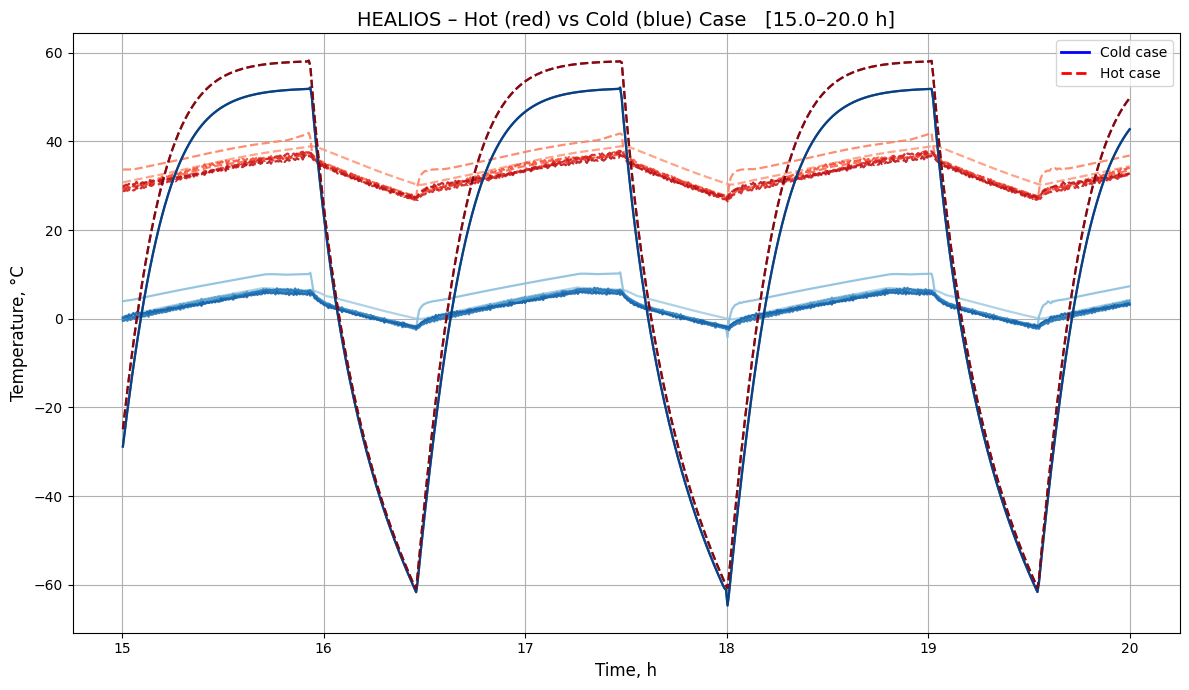

In [17]:
t_start = 15.0   # hours
t_end   = 20.0   # hours

mask = (t_h >= t_start) & (t_h <= t_end)

plt.figure(figsize=(12, 7))

# Colormaps
cmap_cc = plt.cm.Blues
cmap_hc = plt.cm.Reds

colors_cc = cmap_cc(np.linspace(0.35, 0.95, N))
colors_hc = cmap_hc(np.linspace(0.35, 0.95, N))

for i in range(N):
    # Cold case (blue, solid)
    plt.plot(
        t_h[mask],
        sol_CC.y[i][mask] - 273.15,
        color=colors_cc[i],
        linestyle="-",
        linewidth=1.6,
        alpha=0.9
    )

    # Hot case (red, dashed)
    plt.plot(
        t_h[mask],
        sol_HC.y[i][mask] - 273.15,
        color=colors_hc[i],
        linestyle="--",
        linewidth=1.6,
        alpha=0.9
    )

plt.xlabel("Time, h", fontsize=12)
plt.ylabel("Temperature, °C", fontsize=12)
plt.title(f"HEALIOS – Hot (red) vs Cold (blue) Case   [{t_start}–{t_end} h]", fontsize=14)
plt.grid(True)

# Minimal legend (case-level, not node-level)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Cold case'),
    Line2D([0], [0], color='red',  lw=2, linestyle='--', label='Hot case')
]
plt.legend(handles=legend_elements, loc="best")

plt.tight_layout()
plt.show()
